ΚΟΥΤΣΩΝΗ ΕΛΠΙΔΑ-ΜΥΡΤΩ<br>
ΑΕΜ: 02900


# Table of Contents

* [Approaching Categorical Features](#1)
* [Various Approaches to Handle Missing values in Categorical Features](#2)
* [k-Nearest Neighbour Imputation](#3)
* [Evaluation Metrics](#4)
* [Model](#5)
* [Learning Curve](#6)
* [Oversampling using SMOTE](#7)
* [Hyperparameter Tunning](#8)
* [Reference](#9)

## Import important libraries and packages

In [ ]:
!pip install scikit_optimize

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 100 kB 2.8 MB/s 


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import missingno
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix, log_loss, plot_roc_curve, auc, precision_recall_curve
from sklearn.cluster import KMeans
from sklearn.model_selection import StratifiedKFold 
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import RandomForestClassifier
%matplotlib inline
from xgboost import XGBClassifier
from functools import partial
from skopt import gp_minimize
from skopt import space
from skopt.plots import plot_convergence

sns.set_style('whitegrid')

import warnings
warnings.filterwarnings("ignore")

In [ ]:
df_train = pd.read_csv('aug_train.csv')
df_test = pd.read_csv('aug_test.csv')

In [ ]:
df_train.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


In [ ]:
df_test.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours
0,32403,city_41,0.827,Male,Has relevent experience,Full time course,Graduate,STEM,9,<10,NaN,1,21
1,9858,city_103,0.920,Female,Has relevent experience,no_enrollment,Graduate,STEM,5,NaN,Pvt Ltd,1,98
2,31806,city_21,0.624,Male,No relevent experience,no_enrollment,High School,NaN,<1,NaN,Pvt Ltd,never,15
3,27385,city_13,0.827,Male,Has relevent experience,no_enrollment,Masters,STEM,11,10/49,Pvt Ltd,1,39
4,27724,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,10000+,Pvt Ltd,>4,72


Features

* enrollee_id : Unique ID for candidate
* city: City code
* city_ development _index : Developement index of the city (scaled)
* gender: Gender of candidate
* relevent_experience: Relevant experience of candidate
* enrolled_university: Type of University course enrolled if any
* education_level: Education level of candidate
* major_discipline :Education major discipline of candidate
* experience: Candidate total experience in years
* company_size: No of employees in current employer's company
* company_type : Type of current employer
* lastnewjob: Difference in years between previous job and current job
* training_hours: training hours completed
* target: 0 – Not looking for job change, 1 – Looking for a job change

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  19158 non-null  float64
 3   gender                  14650 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  object 
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  last_new_job            18735 non-null  object 
 12  training_hours          19158 non-null  int64  
 13  target                  19158 non-null  float64
dtypes: float64(2), int64(2), object(10)
me

In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2129 entries, 0 to 2128
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             2129 non-null   int64  
 1   city                    2129 non-null   object 
 2   city_development_index  2129 non-null   float64
 3   gender                  1621 non-null   object 
 4   relevent_experience     2129 non-null   object 
 5   enrolled_university     2098 non-null   object 
 6   education_level         2077 non-null   object 
 7   major_discipline        1817 non-null   object 
 8   experience              2124 non-null   object 
 9   company_size            1507 non-null   object 
 10  company_type            1495 non-null   object 
 11  last_new_job            2089 non-null   object 
 12  training_hours          2129 non-null   int64  
dtypes: float64(1), int64(2), object(10)
memory usage: 216.4+ KB


# Approaching Categorical Features<a id = "1" ></a>


Categorical variables/features are any feature type can be classified into two major
types:
*  Nominal
*  Ordinal

**Nominal variables** are variables that have two or more categories which do not
have any kind of order associated with them. For example, if gender is classified
into two groups, i.e. male and female, it can be considered as a nominal variable.

**Ordinal variables** on the other hand, have “levels” or categories with a particular
order associated with them. For example, an ordinal categorical variable can be a
feature with three different levels: low, medium and high. Order is important.

**List of ordinal variables in this data**

1. education_level
2. company_size
3. experience
4. last_new_job
5. company_type

In [ ]:
df_train.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


## Various Approaches to Encode Categorical Features


In [ ]:
#lets combine train and test sets to preprocess the data

#First i suggest to create a fake target feature in test set with some same value for every single element
#By this it will be easy for us to combine and seprate our training and test data after data preprocessing

#can plot count plot for more intution

df_test['target'] = -1 #remeber that we have to drop this column later

df_pre = pd.concat([df_train, df_test], axis = 0).reset_index(drop = True)
# Just a Tip always reset the indices whenever you join or disjoin two or more datasets

In [ ]:
df_pre.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21287 entries, 0 to 21286
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             21287 non-null  int64  
 1   city                    21287 non-null  object 
 2   city_development_index  21287 non-null  float64
 3   gender                  16271 non-null  object 
 4   relevent_experience     21287 non-null  object 
 5   enrolled_university     20870 non-null  object 
 6   education_level         20775 non-null  object 
 7   major_discipline        18162 non-null  object 
 8   experience              21217 non-null  object 
 9   company_size            14727 non-null  object 
 10  company_type            14513 non-null  object 
 11  last_new_job            20824 non-null  object 
 12  training_hours          21287 non-null  int64  
 13  target                  21287 non-null  float64
dtypes: float64(2), int64(2), object(10)
me


**Label Encoding** refers to converting the labels into numeric form so as to convert it into the machine-readable form. Machine learning algorithms can then decide in a better way on how those labels must be operated. It is an important pre-processing step for the structured dataset in supervised learning.
![](https://ekababisong.org/assets/seminar_IEEE/LabelEncoder.png)  

We can do label Encoding From LabelEncoder of scikit-Learn but to do so first we have to impute missing values in data 

In [ ]:
from sklearn.preprocessing import LabelEncoder

#Making Copy of data just for example
df_lb = df_pre.copy()
df_lb['education_level'].value_counts()

Graduate          12867
Masters            4857
High School        2239
Phd                 468
Primary School      344
Name: education_level, dtype: int64

The feature column education_level of data is in categorical form as we can see above output

In [ ]:
#Fill nan values
df_lb.loc[:, "education_level"] = df_lb['education_level'].fillna("NONE")

In above code cell i just create null values as new category "NONE"

In [ ]:
# initialize LabelEncoder
lbl_enc = LabelEncoder()

# fit label encoder and transform values on ord_2 column
df_lb.loc[:, "education_level"] = lbl_enc.fit_transform(df_lb['education_level'].values)

df_lb['education_level'].value_counts()

0    12867
2     4857
1     2239
3      512
4      468
5      344
Name: education_level, dtype: int64

The feature column education_level of data is now transformed into numarical form as we can see above

But in this Notebook i am not going to use scikit-Learn LabelEncoder Due to following reasons

1. Label Encoder encode data on basis of count but as mentioned above this data have lots of ordinal features means categories of some features might depend      upon some levels like in education_level feature\ 

   We know that we should encode data in this order but label encoder encodes it on basis of count
   
      Primary School  
      High School            
      Graduate          
      Masters           
      Phd
    
2. To use label encoder first we have to create NULL values as new category and Our data have so many NULL values so we can not just create new Category for      NULL values because due to this data distribution could change



In [ ]:
# Making Dictionaries of ordinal features

gender_map = {
        'Female': 2,
        'Male': 1,
        'Other': 0
         }

relevent_experience_map = {
    'Has relevent experience':  1,
    'No relevent experience':    0
}

enrolled_university_map = {
    'no_enrollment'   :  0,
    'Full time course':    1, 
    'Part time course':    2 
}
    
education_level_map = {
    'Primary School' :    0,
    'Graduate'       :    2,
    'Masters'        :    3, 
    'High School'    :    1, 
    'Phd'            :    4
    } 
    
major_map ={ 
    'STEM'                   :    0,
    'Business Degree'        :    1, 
    'Arts'                   :    2, 
    'Humanities'             :    3, 
    'No Major'               :    4, 
    'Other'                  :    5 
}
    
experience_map = {
    '<1'      :    0,
    '1'       :    1, 
    '2'       :    2, 
    '3'       :    3, 
    '4'       :    4, 
    '5'       :    5,
    '6'       :    6,
    '7'       :    7,
    '8'       :    8, 
    '9'       :    9, 
    '10'      :    10, 
    '11'      :    11,
    '12'      :    12,
    '13'      :    13, 
    '14'      :    14, 
    '15'      :    15, 
    '16'      :    16,
    '17'      :    17,
    '18'      :    18,
    '19'      :    19, 
    '20'      :    20, 
    '>20'     :    21
} 
    
company_type_map = {
    'Pvt Ltd'               :    0,
    'Funded Startup'        :    1, 
    'Early Stage Startup'   :    2, 
    'Other'                 :    3, 
    'Public Sector'         :    4, 
    'NGO'                   :    5
}

company_size_map = {
    '<10'          :    0,
    '10/49'        :    1, 
    '100-500'      :    2, 
    '1000-4999'    :    3, 
    '10000+'       :    4, 
    '50-99'        :    5, 
    '500-999'      :    6, 
    '5000-9999'    :    7
}
    
last_new_job_map = {
    'never'        :    0,
    '1'            :    1, 
    '2'            :    2, 
    '3'            :    3, 
    '4'            :    4, 
    '>4'           :    5
}

I am using mapping to transform categorical features into numarical features

In [ ]:
# Transforming Categorical features into numarical features

df_pre.loc[:,'education_level'] = df_pre['education_level'].map(education_level_map)
df_pre.loc[:,'company_size'] = df_pre['company_size'].map(company_size_map)
df_pre.loc[:,'company_type'] = df_pre['company_type'].map(company_type_map)
df_pre.loc[:,'last_new_job'] = df_pre['last_new_job'].map(last_new_job_map)
df_pre.loc[:,'major_discipline'] = df_pre['major_discipline'].map(major_map)
df_pre.loc[:,'enrolled_university'] = df_pre['enrolled_university'].map(enrolled_university_map)
df_pre.loc[:,'relevent_experience'] = df_pre['relevent_experience'].map(relevent_experience_map)
df_pre.loc[:,'gender'] = df_pre['gender'].map(gender_map)
df_pre.loc[:,'experience'] = df_pre['experience'].map(experience_map)

#encoding city feature using label encoder
lb_en = LabelEncoder()

df_pre.loc[:,'city'] = lb_en.fit_transform(df_pre.loc[:,'city']) 



In [ ]:
df_pre.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,5,0.920,1.0,1,0.0,2.0,0.0,21.0,NaN,NaN,1.0,36,1.0
1,29725,77,0.776,1.0,0,0.0,2.0,0.0,15.0,5.0,0.0,5.0,47,0.0
2,11561,64,0.624,NaN,0,1.0,2.0,0.0,5.0,NaN,NaN,0.0,83,0.0
3,33241,14,0.789,NaN,0,NaN,2.0,1.0,0.0,NaN,0.0,0.0,52,1.0
4,666,50,0.767,1.0,1,0.0,3.0,0.0,21.0,5.0,1.0,4.0,8,0.0


In [ ]:
df_pre.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21287 entries, 0 to 21286
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             21287 non-null  int64  
 1   city                    21287 non-null  int64  
 2   city_development_index  21287 non-null  float64
 3   gender                  16271 non-null  float64
 4   relevent_experience     21287 non-null  int64  
 5   enrolled_university     20870 non-null  float64
 6   education_level         20775 non-null  float64
 7   major_discipline        18162 non-null  float64
 8   experience              21217 non-null  float64
 9   company_size            14727 non-null  float64
 10  company_type            14513 non-null  float64
 11  last_new_job            20824 non-null  float64
 12  training_hours          21287 non-null  int64  
 13  target                  21287 non-null  float64
dtypes: float64(10), int64(4)
memory usage:

We can use this directly in many tree-based models like:
*  Decision trees
*  Random forest
*  Extra Trees
*  Or any kind of boosted trees model

   * XGBoost
   * GBM
   * LightGBM
   
Generally, in tree-based models the scale of the features does not matter. This is because at each tree level, the score of a possible split will be equal whether the respective feature has been scaled or not.

You can think of it like here: We're dealing with a binary classification problem and the feature we're splitting takes values from 0 to 1000. If you split it on 300, the samples <300 belong 90% to one category while those >300 belong 30% to one category. Now imaging this feature is scaled between 0 and 1. Again, if you split on 0.3, the sample <0.3 belong 90% to one category while those >0.3 belong 30% to one category.

So you've changed the splitting point but the actual distribution of the samples remains the same regarding the target variable.

Above example is taken from : [Why Normalization is not required for tree based models](https://www.kaggle.com/c/m5-forecasting-accuracy/discussion/160613)


This type of encoding cannot be used in linear models, support vector machines or neural networks as they expect data to be normalized (or standardized). For these types of models, we can binarize the data.




#### Approch For Categorical Features(Summary)

1. Fill nan values with some value like NONE to which we can deal later 
2. Then convert categorical features in numarical using label encoder

**NOTE : If you want to use some tree based algorithm than these much steps are sufficent**

3. In case of non tree based model do One Hot Encoding of numarical feature acieved from step 2 and make sparse = True in      One Hot Encoding
4. Now select model and train your data

# Various Approaches to Handle Missing values in Categorical Features <a id = "2" ></a>

1. You can simply drop columns having very large amount of null values
2. Drop entire row if it has some null values (But this approach is **not Recommendable** because then we will lose lots of precious data)
3. First convert none null categorical data into numarical form and then simply fill mean, mode or median value inplace of null values
4. First convert none null categorical data into numarical form and then with the help of k-Nearest Neighbors algorithm find missing values and impute them in    data
5. Another way of imputing missing values in a column would be to train a regression model that tries to predict missing values in a column based on other        columns.

**In This notebook i am using k-Nearest Neighbors algorithm to fill missing values**


Below i am plotting count of values per columns of dataset. I also have sorted columns based on missing values.

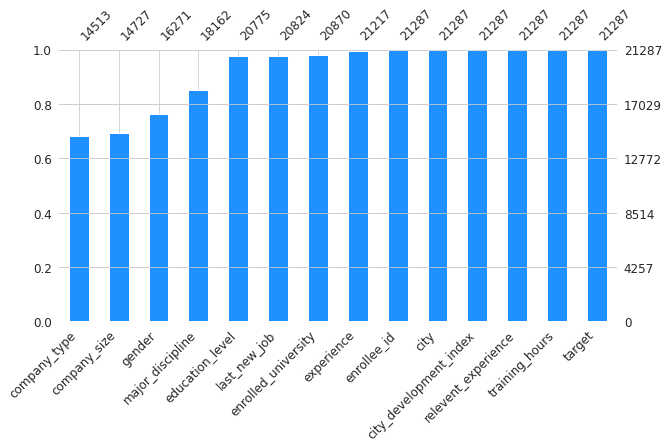

In [ ]:
missingno.bar(df_pre,color="dodgerblue", sort="ascending", figsize=(10,5), fontsize=12);

In [ ]:
#Just to check number of null values of every column in data

for col in df_pre.columns:
    null_val = df_pre[col].isnull().sum()
    null_prec = (null_val * 100) / df_pre.shape[0]
    print('> %s , Missing: %d (%.1f%%)' % (col, null_val, null_prec))

> enrollee_id , Missing: 0 (0.0%)
> city , Missing: 0 (0.0%)
> city_development_index , Missing: 0 (0.0%)
> gender , Missing: 5016 (23.6%)
> relevent_experience , Missing: 0 (0.0%)
> enrolled_university , Missing: 417 (2.0%)
> education_level , Missing: 512 (2.4%)
> major_discipline , Missing: 3125 (14.7%)
> experience , Missing: 70 (0.3%)
> company_size , Missing: 6560 (30.8%)
> company_type , Missing: 6774 (31.8%)
> last_new_job , Missing: 463 (2.2%)
> training_hours , Missing: 0 (0.0%)
> target , Missing: 0 (0.0%)


Below we are plotting heatmap showing nullity correlation between various columns of dataset.

The nullity correlation ranges from -1 to 1.

* -1 - Exact Negative correlation represents that if the value of one variable is present then the value of other variables is definitely absent.
* 0 - No correlation represents that variables values present or absent do not have any effect on one another.
* 1 - Exact Positive correlation represents that if the value of one variable is present then the value of the other is definitely present.

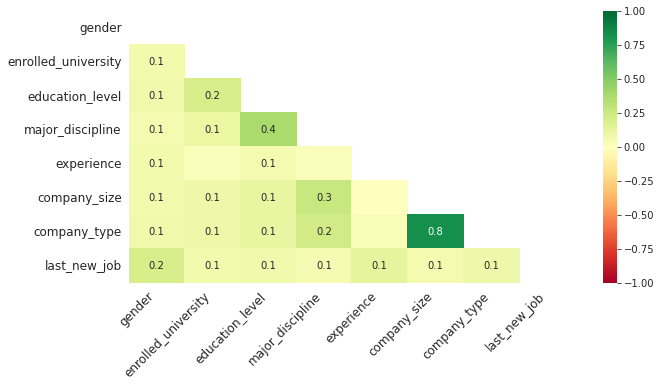

In [ ]:
missingno.heatmap(df_pre, cmap="RdYlGn", figsize=(10,5), fontsize=12);

# <center> k-Nearest Neighbour Imputation <a id = "3" ></a> </center>


A fancy way of filling in the missing values would be to use a **k-nearest neighbour** method. You can select a sample with missing values and find the nearest
neighbours utilising some kind of distance metric, for example, Euclidean distance. Then you can take the mean of all nearest neighbours and fill up the missing value. You can use the KNN imputer implementation for filling missing values like this.

![image1](https://static.javatpoint.com/tutorial/machine-learning/images/k-nearest-neighbor-algorithm-for-machine-learning2.png)


[K-Nearest Neighbors (KNN) Algorithm for Machine Learning](https://medium.com/capital-one-tech/k-nearest-neighbors-knn-algorithm-for-machine-learning-e883219c8f26)


### How it works?

Step-1: Select the K number of the neighbors
        
let say we select K = 5
        
![image2](https://static.javatpoint.com/tutorial/machine-learning/images/k-nearest-neighbor-algorithm-for-machine-learning3.png) 


Step-2: Calculate the Euclidean distance of K number of neighbors

In this step we search for those k = 5 neighbors having minimum Euclidean Distance from unknown data point


![Image4](https://static.javatpoint.com/tutorial/machine-learning/images/k-nearest-neighbor-algorithm-for-machine-learning4.png)

        
Step-3: Among these k neighbors, count the number of the data points in each category.

![image3](https://static.javatpoint.com/tutorial/machine-learning/images/k-nearest-neighbor-algorithm-for-machine-learning5.png)


Step-4: Assign the new data points to that category for which the number of the neighbor is maximum.

You can also visit below given youtube video link to understand it bit nicely

[Step-by-Step procedure of KNN Imputer for imputing missing values](https://www.youtube.com/watch?v=AHBHMQyD75U)

In [ ]:
df_pre1 = df_pre.copy()

In [ ]:
knn_imputer = KNNImputer(n_neighbors = 3)

X = np.round(knn_imputer.fit_transform(df_pre1))
df_pre1 = pd.DataFrame(X, columns = df_pre1.columns)

In [ ]:
df_pre1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21287 entries, 0 to 21286
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             21287 non-null  float64
 1   city                    21287 non-null  float64
 2   city_development_index  21287 non-null  float64
 3   gender                  21287 non-null  float64
 4   relevent_experience     21287 non-null  float64
 5   enrolled_university     21287 non-null  float64
 6   education_level         21287 non-null  float64
 7   major_discipline        21287 non-null  float64
 8   experience              21287 non-null  float64
 9   company_size            21287 non-null  float64
 10  company_type            21287 non-null  float64
 11  last_new_job            21287 non-null  float64
 12  training_hours          21287 non-null  float64
 13  target                  21287 non-null  float64
dtypes: float64(14)
memory usage: 2.3 MB


In [ ]:
df_pre1.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949.0,5.0,1.0,1.0,1.0,0.0,2.0,0.0,21.0,4.0,0.0,1.0,36.0,1.0
1,29725.0,77.0,1.0,1.0,0.0,0.0,2.0,0.0,15.0,5.0,0.0,5.0,47.0,0.0
2,11561.0,64.0,1.0,1.0,0.0,1.0,2.0,0.0,5.0,1.0,0.0,0.0,83.0,0.0
3,33241.0,14.0,1.0,1.0,0.0,1.0,2.0,1.0,0.0,1.0,0.0,0.0,52.0,1.0
4,666.0,50.0,1.0,1.0,1.0,0.0,3.0,0.0,21.0,5.0,1.0,4.0,8.0,0.0


But wait as you can observe city_development_index feature values were in continues form before imputation and after imputation now they are in discrete form.
As you may also noticed i was rounding values after imputation because of this city_development_index values converted into discrete form

I am plotting kernel density estimate plot just to check distribution of city_development_index feature before and after imputation. You can plot KDE plots for every feature to check effect of imputaion on data

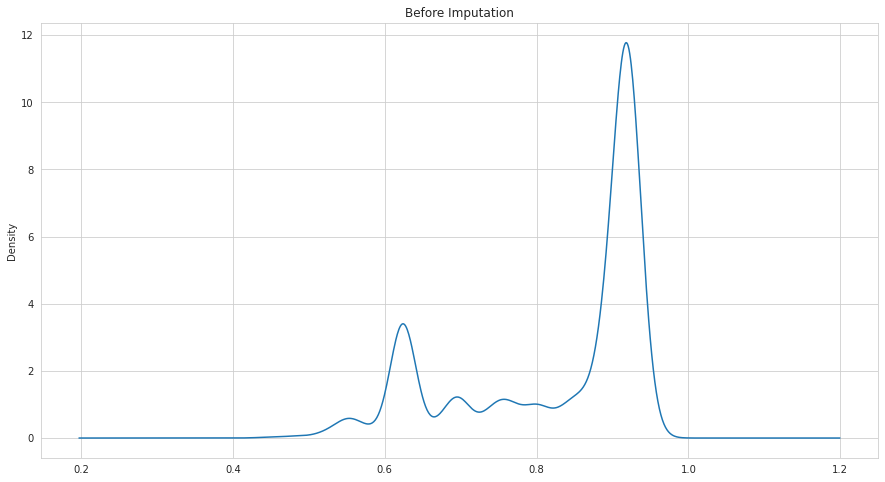

In [ ]:
plt.figure(figsize = (15,8))
plt.title('Before Imputation')
df_pre['city_development_index'].plot(kind = 'kde')
plt.show()

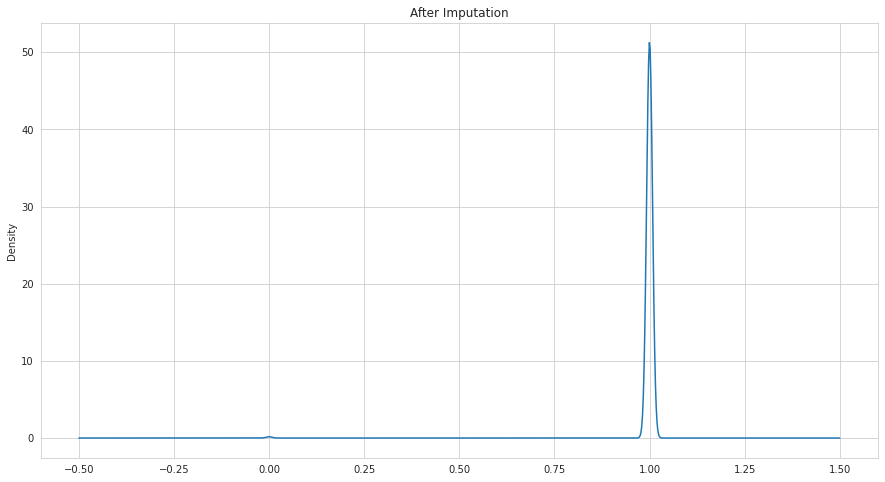

In [ ]:
plt.figure(figsize = (15,8))
plt.title('After Imputation')
df_pre1['city_development_index'].plot(kind = 'kde')
plt.show()

So rather than using imputation on whole dataset just use it on those features having missing values.

In [ ]:
# missing columns

missing_cols = df_pre.columns[df_pre.isna().any()].tolist()
missing_cols

['gender',
 'enrolled_university',
 'education_level',
 'major_discipline',
 'experience',
 'company_size',
 'company_type',
 'last_new_job']

Above shown columns have missing values and all 8 are categorical features

Now i would like make two different dataframes one having features with missing values and second having features without missing values. But there will be one common column enrollee_id so that later we can perform inner join on both dataframes

In [ ]:
#dataframe having features with missing values
df_missing = df_pre[['enrollee_id'] + missing_cols]

#dataframe having features without missing values
df_non_missing = df_pre.drop(missing_cols, axis = 1)

In [ ]:
#k-Nearest Neighbour Imputation

knn_imputer = KNNImputer(n_neighbors = 3)

X = np.round(knn_imputer.fit_transform(df_missing))
#Rounding them because these are categorical features

df_missing = pd.DataFrame(X, columns = df_missing.columns)

In [ ]:
#now lets join both dataframes 

df_pre2 = pd.merge(df_missing, df_non_missing, on = 'enrollee_id')

If you remember i did concatenation between train and test data before preprocessing. Now after preprocessing of data we can seprate train and test data

In [ ]:
train = df_pre2[df_pre2['target'] != -1].reset_index(drop = True)
test = df_pre2[df_pre2['target'] == -1].reset_index(drop = True)

X = train.drop(['enrollee_id', 'target'], axis = 1)
Y = train['target']

# drop fake target feature from test data 
test = test.drop('target', axis = 1)

# Evaluation Metrics <a id = "4" ></a>

I think before selecting an optimal model for given data first we have to analayze target feature. Target Feature can be discrete in case of classification problem or continuous in case of Regression Problem

If we talk briefly about classification problems, the most common metrics used are:


- **[Accuracy](https://blog.exsilio.com/all/accuracy-precision-recall-f1-score-interpretation-of-performance-measures/)** : It is one of the most straightforward metrics used in machine learning. It defines how accurate your model is. For example, if you build a model that classifies 90 samples accurately, your accuracy is 90% or 0.90. If only 83 samples are classified correctly, the accuracy of your model is 83% or 0.83. Simple.
             
     **[Scikit-learn user guide for accuracy](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)**
     

- **[Precision](https://blog.exsilio.com/all/accuracy-precision-recall-f1-score-interpretation-of-performance-measures/)** :  Precision is the ratio of correctly predicted positive observations to the total predicted positive observations. The question that this metric answer is of all passengers that labeled as survived, how many actually survived? High precision relates to the low false positive rate. We have got 0.788 precision which is pretty good

     **[True Positives (TP)](https://blog.exsilio.com/all/accuracy-precision-recall-f1-score-interpretation-of-performance-measures/)** - These are the correctly predicted positive values which means that the value of actual class is yes and the value of predicted  class is also yes. E.g. if actual class value indicates that this passenger survived and predicted class tells you the same thing.

     **[True Negatives (TN)](https://blog.exsilio.com/all/accuracy-precision-recall-f1-score-interpretation-of-performance-measures/)** - These are the correctly predicted negative values which means that the value of actual class is no and value of predicted class is also no. E.g. if actual class says this passenger did not survive and predicted class tells you the same thing.

     False positives and false negatives, these values occur when your actual class contradicts with the predicted class.

     **[False Positives (FP)](https://blog.exsilio.com/all/accuracy-precision-recall-f1-score-interpretation-of-performance-measures/)** – When actual class is no and predicted class is yes. E.g. if actual class says this passenger did not survive but predicted class tells you that this passenger will survive.

     **[False Negatives (FN)](https://blog.exsilio.com/all/accuracy-precision-recall-f1-score-interpretation-of-performance-measures/)** – When actual class is yes but predicted class in no. E.g. if actual class value indicates that this passenger survived and predicted class tells you that passenger will die.

     **[Scikit-learn user guide for Precision ](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html#sklearn.metrics.precision_score)**
     
     ![](https://2.bp.blogspot.com/-EvSXDotTOwc/XMfeOGZ-CVI/AAAAAAAAEiE/oePFfvhfOQM11dgRn9FkPxlegCXbgOF4QCLcBGAs/s1600/confusionMatrxiUpdated.jpg)     
     

- **[Recall(Sensitivity)](https://blog.exsilio.com/all/accuracy-precision-recall-f1-score-interpretation-of-performance-measures/)** : Recall is the ratio of correctly predicted positive observations to the all observations in actual class - yes. The question recall answers is: Of all the passengers that truly survived, how many did we label? We have got recall of 0.631 which is good for this model as it’s above 0.5.

     **[Scikit-learn user guide for Recall](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html#sklearn.metrics.recall_score)**


- **[Confusion Matrix](https://www.geeksforgeeks.org/confusion-matrix-machine-learning/)** : A much better way to evaluate the performance of a classifier is to look at the confusion matrix. The general idea is to count the number of times instances of class A are classified as class B. For example, to know the number of times the classifier confused images of 5s with 3s, you would look in the 5th row and 3rd column of the confusion matrix.

    **[Scikit-Learn user guide for Confusion Matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)**
     
     
- **[F1 score (F1)](https://blog.exsilio.com/all/accuracy-precision-recall-f1-score-interpretation-of-performance-measures/)** : F1 Score is the weighted average of Precision and Recall. Therefore, this score takes both false positives and false negatives into account. Intuitively it is not as easy to understand as accuracy, but F1 is usually more useful than accuracy, especially if you have an uneven class distribution. Accuracy works best if false positives and false negatives have similar cost. If the cost of false positives and false negatives are very different, it’s better to look at both Precision and Recall. In our case, F1 score is 0.701. 

     **[Scikit-learn user guide for F1 score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html)**


- **[Area under the ROC (Receiver Operating Characteristic) curve](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)** : AUC - ROC curve is a performance measurement for the classification problems at various threshold settings. ROC is a probability curve and AUC represents the degree or measure of separability. It tells how much the model is capable of distinguishing between classes. Higher the AUC, the better the model is at predicting 0s as 0s and 1s as 1s. By analogy, the Higher the AUC, the better the model is at distinguishing between patients with the disease and no disease.

     **[Scikit-learn user guide for AUC under the ROC curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html)**






**When it comes to regression, the most commonly used [evaluation metrics](https://towardsdatascience.com/evaluation-metrics-model-selection-in-linear-regression-73c7573208be) are:**


- Mean absolute error (MAE)
- Mean squared error (MSE)
- Root mean squared error (RMSE)
- Root mean squared logarithmic error (RMSLE)
- Mean percentage error (MPE)
- Mean absolute percentage error (MAPE)
- R2

 **[Scikit-learn user guide for regression evaluation metrics](https://scikit-learn.org/stable/modules/model_evaluation.html)**

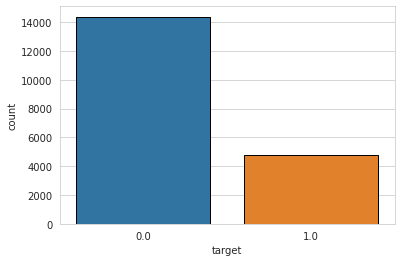

In [ ]:
sns.countplot(train['target'], edgecolor = 'black')

We see that the target is **skewed** and thus the best metric for this binary classification problem would be Area Under the ROC Curve (AUC). We can use precision and recall too, but AUC combines these two metrics. Thus, we will be using AUC to evaluate the model that we build on this dataset.

# Model <a id = "5"></a>

[Extreme Gradient Boosting (XGBoost)](https://machinelearningmastery.com/extreme-gradient-boosting-ensemble-in-python/) Classifier

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size = 0.2 ,random_state = 42)

clf = XGBClassifier()

clf.fit(X_train, y_train)

y_train_pred = clf.predict_proba(X_train)
y_train_pred_pos = y_train_pred[:,1]

y_val_pred = clf.predict_proba(X_val)
y_val_pred_pos = y_val_pred[:,1]

auc_train = roc_auc_score(y_train, y_train_pred_pos)
auc_test = roc_auc_score(y_val, y_val_pred_pos)

print(f"Train AUC Score {auc_train}")
print(f"Test AUC Score {auc_test}")

fpr, tpr, _ = roc_curve(y_val, y_val_pred_pos)

Train AUC Score 0.7925329482574122
Test AUC Score 0.7754549997082166


As we can see model is overfitting the data, we can do various things to resolve this problem like we can increase data set size in balanced manner and we can also tune hyperparameters of model 

Let's plot AUC Curve

In [ ]:
def plot_auc_curve(fpr, tpr, auc):
    plt.figure(figsize = (16,6))
    plt.plot(fpr,tpr,'b+',linestyle = '-')
    plt.fill_between(fpr, tpr, alpha = 0.5)
    plt.ylabel('True Postive Rate')
    plt.xlabel('False Postive Rate')
    plt.title(f'ROC Curve Having AUC = {auc}')

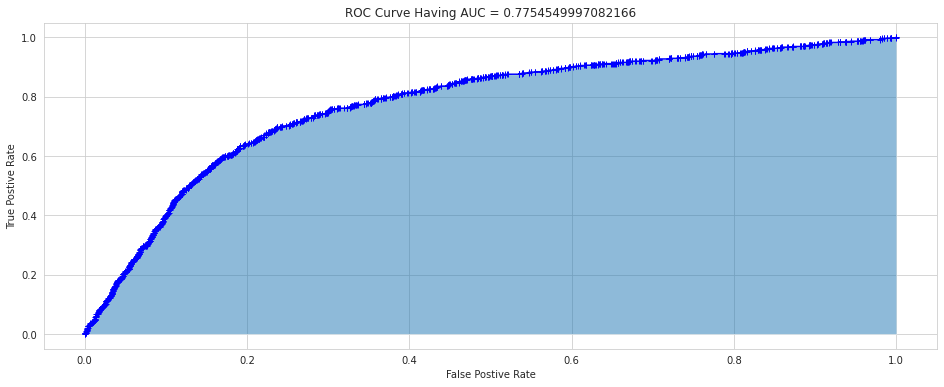

In [ ]:
plot_auc_curve(fpr, tpr, auc_test)

# Learning Curve <a id = "6"></a>


Training 3 examples will easily have 0 errors because we can always find any curve that exactly touches 3 points.

* As the training set gets larger, the error for a function increases. 
* The error value will plateau out after a certain m, or training set size.


**With high bias**


* Low training set size: causes training cost to be low and cross validation cost to be high
* Large training set size: causes both training cost and cross validation cost to be high with training cost = cross validation cost


![img1](https://www.dataquest.io/wp-content/uploads/2019/01/low_high_var.png)

**If a learning algorithm is suffering from high bias, getting more training data will not (by itself) help much.**


For high variance, we have the following relationships in terms of the training set size:


**With high variance**


* Low training set size: training cost will be low and cross validation cost will be high
* Large training set size: training cost increases with training set size and cross validation cost decreases without leveling off. Also, training cost < cross   validation cost but the difference between them remains significant.

**If a learning algorithm is suffering from high variance, getting more training data is likely to help.**

You can visit below given link for more detailed intuition

[Learning Curves for machine learning](https://www.dataquest.io/blog/learning-curves-machine-learning/)

In [ ]:
# funtion to plot learning curves

def plot_learning_cuve(model, X, Y):
    
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 11)
    train_loss, test_loss = [], []
    
    for m in range(200,len(x_train),200):
        
        model.fit(x_train.iloc[:m,:], y_train[:m])
        y_train_prob_pred = model.predict_proba(x_train.iloc[:m,:])
        train_loss.append(log_loss(y_train[:m], y_train_prob_pred))
        
        y_test_prob_pred = model.predict_proba(x_test)
        test_loss.append(log_loss(y_test, y_test_prob_pred))
        
    plt.figure(figsize = (15,8))
    plt.plot(train_loss, 'r-+', label = 'Training Loss')
    plt.plot(test_loss, 'b-', label = 'Test Loss')
    plt.xlabel('Number Of Batches')
    plt.ylabel('Log-Loss')
    plt.legend(loc = 'best')



    plt.show()
        

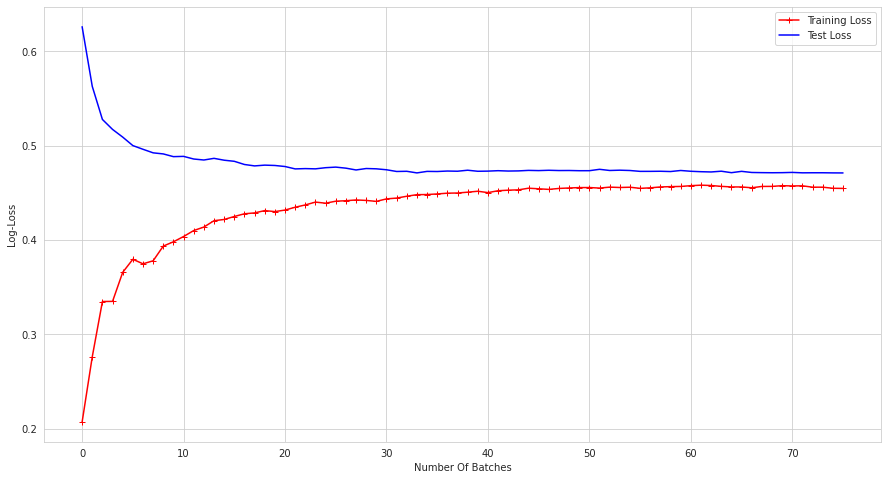

In [ ]:
plot_learning_cuve(XGBClassifier(), X, Y)

It's a high variance problem 

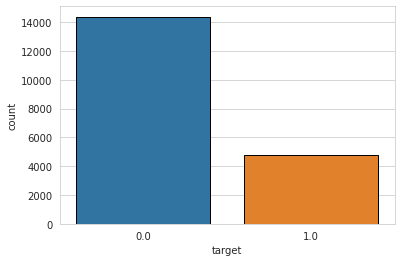

In [ ]:
sns.countplot(Y, edgecolor = 'black')

Let's try to increase data in balanced manner using Synthetic Minority Oversampling Technique (SMOTE) 

# Oversampling using SMOTE <a id = "7"></a>

[SMOTE for Imbalanced Classification](https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/)\
[SMOTE implementation](https://imbalanced-learn.org/stable/generated/imblearn.over_sampling.SMOTE.html)

In [ ]:
from imblearn.over_sampling import SMOTE

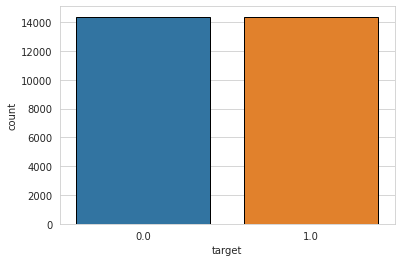

In [ ]:
smote = SMOTE(random_state = 402)
X_smote, Y_smote = smote.fit_resample(X,Y)


sns.countplot(Y_smote, edgecolor = 'black')

In [ ]:
print(X_smote.shape)

(28762, 12)


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_smote, Y_smote, test_size = 0.2 ,random_state = 42)

clf = XGBClassifier()

clf.fit(X_train, y_train)

y_train_pred = clf.predict_proba(X_train)
y_train_pred_pos = y_train_pred[:,1]

y_val_pred = clf.predict_proba(X_val)
y_val_pred_pos = y_val_pred[:,1]

auc_train = roc_auc_score(y_train, y_train_pred_pos)
auc_test = roc_auc_score(y_val, y_val_pred_pos)

print(f"Train AUC Score {auc_train}")
print(f"Test AUC Score {auc_test}")

Train AUC Score 0.9195792412623405
Test AUC Score 0.9169873603076146


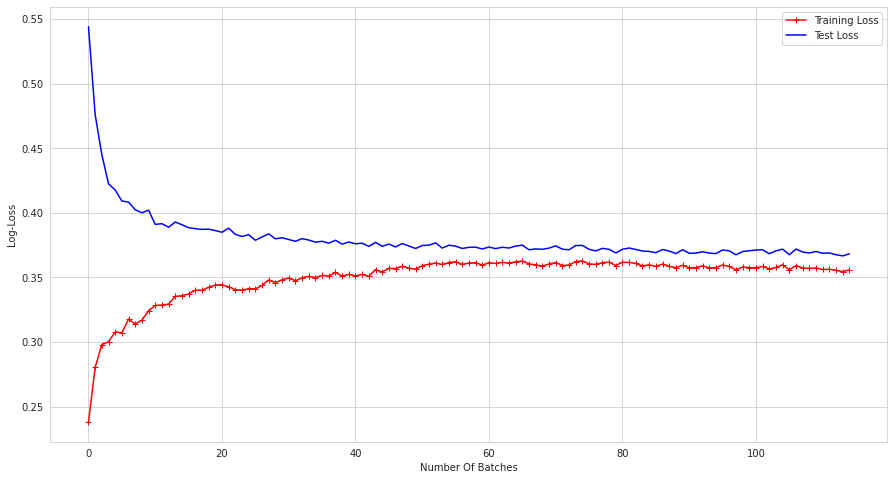

In [ ]:
plot_learning_cuve(XGBClassifier(), X_smote, Y_smote)

# Hyperparameter Tunning <a id = "8"></a>

The parameters that the model has here are known as hyper-parameters, i.e. the parameters that control the training/fitting process of the model.

Let’s say there are three parameters a, b, c in the model, and
all these parameters can be integers between 1 and 10. A “correct” combination of
these parameters will provide you with the best result. So, it’s kind of like a suitcase
with a 3-dial combination lock. However, in 3 dial combination lock has only one
correct answer. The model has many right answers. So, how would you find the
best parameters? A method would be to evaluate all the combinations and see which
one improves the metric. We go through all the parameters from 1 to 10. So, we have a
total of 1000 (10 x 10 x 10) fits for the model. Well, that might be expensive because
the model can take a long time to train. Let's visit some efficient methods

* [Random Search](https://machinelearningmastery.com/hyperparameter-optimization-with-random-search-and-grid-search/) : Define a search space as a bounded domain of hyperparameter values and randomly sample points in that domain.\
   [Scikit-Learn User Guide for Random Search](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)
   
   
* [Grid Search](https://machinelearningmastery.com/hyperparameter-optimization-with-random-search-and-grid-search/) : Define a search space as a grid of hyperparameter values and evaluate every position in the grid.\
   [Scikit-Learn User Guide for Grid Search](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)
   
   
Visit below given link for deep intuition of Random search and Grid search

[Hyperparameter Optimization With Random Search and Grid Search](https://machinelearningmastery.com/hyperparameter-optimization-with-random-search-and-grid-search/)

In this notebook i am using **Bayesian optimization with gaussian process**

[Hyperparameter Tuning With Bayesian Optimization](https://machinelearningmastery.com/what-is-bayesian-optimization/)


Bayesian optimization algorithm need a function they can optimize. Most of the time, it’s about the minimization of this function, like we minimize loss.

In [ ]:
def optimize(params, param_names, x, y):
   

    # convert params to dictionary
    params = dict(zip(param_names, params))

    # initialize model with current parameters
    clf = XGBClassifier(tree_method = 'hist', **params)
    
    # initialize stratified k fold
    kf = StratifiedKFold(n_splits = 5)
    
    i = 0
    
    # initialize auc scores list
    auc_scores = []
    
    #loop over all folds
    for index in kf.split(X = x, y = y):
        train_index, test_index = index[0], index[1]
        
        
        
        x_train = x.iloc[train_index,:]
        y_train = y[train_index]

        smote = SMOTE(random_state = 446)
        x_train, y_train = smote.fit_resample(x_train,y_train)
        
        x_test = x.iloc[test_index,:]
        y_test = y[test_index]
        
        #fit model
        clf.fit(x_train, y_train)
        
        y_pred = clf.predict_proba(x_test)
        y_pred_pos = y_pred[:,1]
        
        auc = roc_auc_score(y_test, y_pred_pos)
        print(f'Current parameters of fold number {i} -> {params}')
        print(f'AUC score of test {i} f {auc}')

        i = i+1
        auc_scores.append(auc)
        
    return -1 * np.mean(auc_scores)
    
    

So, let’s say, you want to find the best parameters for best accuracy and obviously, the more the accuracy is better. Now we cannot minimize the accuracy, but we can minimize it when we multiply it by -1. This way, we are minimizing the negative of accuracy, but in fact, we are maximizing accuracy. Using Bayesian optimization with gaussian process can be accomplished by using [gp_minimize function from scikit-optimize (skopt) library](https://scikit-optimize.github.io/stable/modules/generated/skopt.gp_minimize.html). Let’s take a look at how we can tune the parameters of our xgboost model using this
function.

[Parameters for XGBoost Classifier](https://xgboost.readthedocs.io/en/latest/parameter.html)

I am try to optimize the model with 4 hyperparameters but you can try many more given in above mentioned link

In [ ]:
#define a parameter space

param_spaces = [space.Integer(100, 2000, name = 'n_estimators'),
                space.Real(0.01,100, name = 'min_child_weight'),
                space.Real(0.01,1000, name = 'gamma'),
                space.Real(0.1, 1, prior = 'uniform', name = 'colsample_bytree'),
]

# make a list of param names this has to be same order as the search space inside the main function
param_names = ['n_estimators' ,'min_child_weight', 'gamma', 'colsample_bytree']

# by using functools partial, i am creating a new function which has same parameters as the optimize function except 
# for the fact that only one param, i.e. the "params" parameter is required. 
# This is how gp_minimize expects the optimization function to be. 
# You can get rid of this by reading data inside the optimize function or by defining the optimize function here.

optimize_function = partial(optimize, param_names = param_names, x = X, y = Y)

In [ ]:
# output of this cell is very large that's why it is hidden

result = gp_minimize(optimize_function, dimensions = param_spaces, n_calls = 20, n_random_starts = 5, verbose = 10)

In [ ]:
best_params = dict(zip(param_names, result.x))
print(f'Best Parameters : {best_params}')
print(f'Best AUC score : {result.fun}')

Best Parameters : {'n_estimators': 1427, 'min_child_weight': 14.487371083304206, 'gamma': 2.087592593725312, 'colsample_bytree': 0.9653501230577264}
Best AUC score : -0.7711802076389354


let's again plot learning cuve with hyperparameters this time

In [ ]:
# splitting train and validation data

X_train, X_val, y_train, y_val = train_test_split(X,Y, test_size = 0.2, random_state = 24)

smote = SMOTE(random_state = 446)
X_train, y_train = smote.fit_resample(X_train,y_train)

In [ ]:
# initialize model with best parameters
clf = XGBClassifier(**best_params)

# fit model
clf.fit(X_train, y_train)

# predicting probabilities of training data
y_train_pred = clf.predict_proba(X_train)


y_train_pred_pos = y_train_pred[:,1]

y_val_pred = clf.predict_proba(X_val)
y_val_pred_pos = y_val_pred[:,1]

auc_train = roc_auc_score(y_train, y_train_pred_pos)
auc_test = roc_auc_score(y_val, y_val_pred_pos)

print(f"Train AUC Score {auc_train}")
print(f"Test AUC Score {auc_test}")

fpr, tpr, _ = roc_curve(y_val, y_val_pred_pos)

Train AUC Score 0.9321232324893449
Test AUC Score 0.7765317651440233


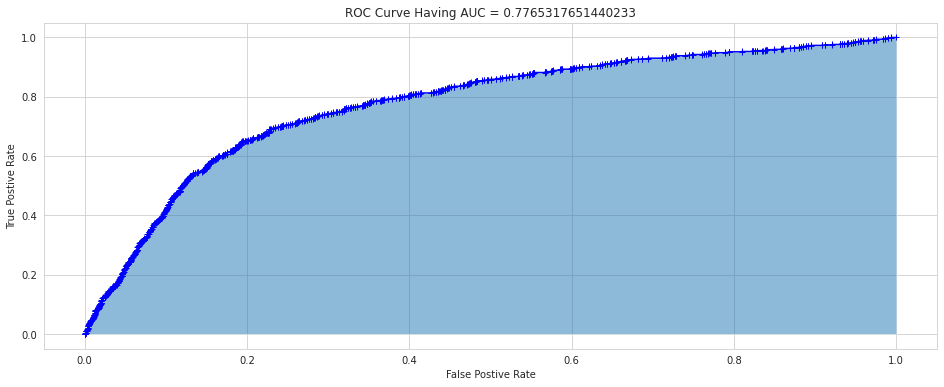

In [ ]:
plot_auc_curve(fpr, tpr, auc_test)

# LightGBM

In [ ]:
import lightgbm as ltb

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_smote, Y_smote, test_size = 0.2 ,random_state = 42)

clf = ltb.LGBMClassifier()

clf.fit(X_train, y_train)

y_train_pred = clf.predict_proba(X_train)
y_train_pred_pos = y_train_pred[:,1]

y_val_pred = clf.predict_proba(X_val)
y_val_pred_pos = y_val_pred[:,1]

auc_train = roc_auc_score(y_train, y_train_pred_pos)
auc_test = roc_auc_score(y_val, y_val_pred_pos)

print(f"Train AUC Score {auc_train}")
print(f"Test AUC Score {auc_test}")

Train AUC Score 0.9474412883012104
Test AUC Score 0.9250853732760373


## Hyper-parameter tuning

In [ ]:
def optimize(params, param_names, x, y):
   

    # convert params to dictionary
    params = dict(zip(param_names, params))

    # initialize model with current parameters
    clf = ltb.LGBMClassifier(**params)
    
    # initialize stratified k fold
    kf = StratifiedKFold(n_splits = 5)
    
    i = 0
    
    # initialize auc scores list
    auc_scores = []
    
    #loop over all folds
    for index in kf.split(X = x, y = y):
        train_index, test_index = index[0], index[1]
        
        
        
        x_train = x.iloc[train_index,:]
        y_train = y[train_index]

        smote = SMOTE(random_state = 446)
        x_train, y_train = smote.fit_resample(x_train,y_train)
        
        x_test = x.iloc[test_index,:]
        y_test = y[test_index]
        
        #fit model
        clf.fit(x_train, y_train)
        
        y_pred = clf.predict_proba(x_test)
        y_pred_pos = y_pred[:,1]
        
        auc = roc_auc_score(y_test, y_pred_pos)
        print(f'Current parameters of fold number {i} -> {params}')
        print(f'AUC score of test {i} f {auc}')

        i = i+1
        auc_scores.append(auc)
        
    return -1 * np.mean(auc_scores)

In [ ]:
#define a parameter space

param_spaces = [space.Integer(100, 200, name = 'n_estimators'),
                space.Real(0.001,1, name = 'min_child_weight'),
]

# make a list of param names this has to be same order as the search space inside the main function
param_names = ['n_estimators' ,'min_child_weight']

# by using functools partial, i am creating a new function which has same parameters as the optimize function except 
# for the fact that only one param, i.e. the "params" parameter is required. 
# This is how gp_minimize expects the optimization function to be. 
# You can get rid of this by reading data inside the optimize function or by defining the optimize function here.

optimize_function = partial(optimize, param_names = param_names, x = X, y = Y)

In [ ]:
# output of this cell is very large that's why it is hidden

result = gp_minimize(optimize_function, dimensions = param_spaces, n_calls = 20, n_random_starts = 5, verbose = 10)

Iteration No: 1 started. Evaluating function at random point.
Current parameters of fold number 0 -> {'n_estimators': 132, 'min_child_weight': 0.10158155878090312}
AUC score of test 0 f 0.7714607907891597
Current parameters of fold number 1 -> {'n_estimators': 132, 'min_child_weight': 0.10158155878090312}
AUC score of test 1 f 0.7794303673162982
Current parameters of fold number 2 -> {'n_estimators': 132, 'min_child_weight': 0.10158155878090312}
AUC score of test 2 f 0.7547918406862878
Current parameters of fold number 3 -> {'n_estimators': 132, 'min_child_weight': 0.10158155878090312}
AUC score of test 3 f 0.773189748705663
Current parameters of fold number 4 -> {'n_estimators': 132, 'min_child_weight': 0.10158155878090312}
AUC score of test 4 f 0.7652101886710018
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 3.2428
Function value obtained: -0.7688
Current minimum: -0.7688
Iteration No: 2 started. Evaluating function at random point.
Current parameters of fold nu

In [ ]:
best_params = dict(zip(param_names, result.x))
print(f'Best Parameters : {best_params}')
print(f'Best AUC score : {result.fun}')

Best Parameters : {'n_estimators': 100, 'min_child_weight': 1.0}
Best AUC score : -0.7708578085531556


let's again plot learning cuve with hyperparameters this time

In [ ]:
# splitting train and validation data

X_train, X_val, y_train, y_val = train_test_split(X,Y, test_size = 0.2, random_state = 24)

smote = SMOTE(random_state = 446)
X_train, y_train = smote.fit_resample(X_train,y_train)

In [ ]:
# initialize model with best parameters
clf = ltb.LGBMClassifier(**best_params)

# fit model
clf.fit(X_train, y_train)

# predicting probabilities of training data
y_train_pred = clf.predict_proba(X_train)


y_train_pred_pos = y_train_pred[:,1]

y_val_pred = clf.predict_proba(X_val)
y_val_pred_pos = y_val_pred[:,1]

auc_train = roc_auc_score(y_train, y_train_pred_pos)
auc_test = roc_auc_score(y_val, y_val_pred_pos)

print(f"Train AUC Score {auc_train}")
print(f"Test AUC Score {auc_test}")

fpr, tpr, _ = roc_curve(y_val, y_val_pred_pos)

Train AUC Score 0.9483250738999687
Test AUC Score 0.7814461966628167


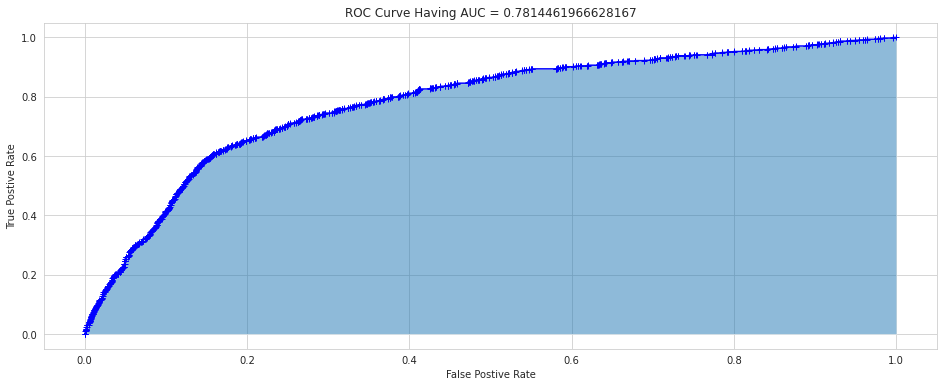

In [ ]:
plot_auc_curve(fpr, tpr, auc_test)

# CatBoost

In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from catboost import CatBoostClassifier

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_smote, Y_smote, test_size = 0.2 ,random_state = 42)

clf = CatBoostClassifier()

clf.fit(X_train, y_train, verbose=0)

y_train_pred = clf.predict_proba(X_train)
y_train_pred_pos = y_train_pred[:,1]

y_val_pred = clf.predict_proba(X_val)
y_val_pred_pos = y_val_pred[:,1]

auc_train = roc_auc_score(y_train, y_train_pred_pos)
auc_test = roc_auc_score(y_val, y_val_pred_pos)

print(f"Train AUC Score {auc_train}")
print(f"Test AUC Score {auc_test}")

Train AUC Score 0.9578969074641914
Test AUC Score 0.9253757318486311


## Hyper-parameter tuning

In [ ]:
def optimize(params, param_names, x, y):
   

    # convert params to dictionary
    params = dict(zip(param_names, params))

    # initialize model with current parameters
    clf = CatBoostClassifier(**params)
    
    # initialize stratified k fold
    kf = StratifiedKFold(n_splits = 5)
    
    i = 0
    
    # initialize auc scores list
    auc_scores = []
    
    #loop over all folds
    for index in kf.split(X = x, y = y):
        train_index, test_index = index[0], index[1]
        
        
        
        x_train = x.iloc[train_index,:]
        y_train = y[train_index]

        smote = SMOTE(random_state = 446)
        x_train, y_train = smote.fit_resample(x_train,y_train)
        
        x_test = x.iloc[test_index,:]
        y_test = y[test_index]
        
        #fit model
        clf.fit(x_train, y_train, verbose=0)
        
        y_pred = clf.predict_proba(x_test)
        y_pred_pos = y_pred[:,1]
        
        auc = roc_auc_score(y_test, y_pred_pos)
        print(f'Current parameters of fold number {i} -> {params}')
        print(f'AUC score of test {i} f {auc}')

        i = i+1
        auc_scores.append(auc)
        
    return -1 * np.mean(auc_scores)

In [ ]:
#define a parameter space

param_spaces = [space.Integer(100, 1000, name = 'n_estimators')]

# make a list of param names this has to be same order as the search space inside the main function
param_names = ['n_estimators']

# by using functools partial, i am creating a new function which has same parameters as the optimize function except 
# for the fact that only one param, i.e. the "params" parameter is required. 
# This is how gp_minimize expects the optimization function to be. 
# You can get rid of this by reading data inside the optimize function or by defining the optimize function here.

optimize_function = partial(optimize, param_names = param_names, x = X, y = Y)

In [ ]:
# output of this cell is very large that's why it is hidden

result = gp_minimize(optimize_function, dimensions = param_spaces, n_calls = 5, n_random_starts = 5, verbose = 10)

Iteration No: 1 started. Evaluating function at random point.
Current parameters of fold number 0 -> {'n_estimators': 312}
AUC score of test 0 f 0.7649178601148736
Current parameters of fold number 1 -> {'n_estimators': 312}
AUC score of test 1 f 0.7748761936906792
Current parameters of fold number 2 -> {'n_estimators': 312}
AUC score of test 2 f 0.7555714485893719
Current parameters of fold number 3 -> {'n_estimators': 312}
AUC score of test 3 f 0.7750304014447058
Current parameters of fold number 4 -> {'n_estimators': 312}
AUC score of test 4 f 0.7593059368378129
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 20.6987
Function value obtained: -0.7659
Current minimum: -0.7659
Iteration No: 2 started. Evaluating function at random point.
Current parameters of fold number 0 -> {'n_estimators': 499}
AUC score of test 0 f 0.7702240006750427
Current parameters of fold number 1 -> {'n_estimators': 499}
AUC score of test 1 f 0.7804518421098574
Current parameters of fold n

In [ ]:
best_params = dict(zip(param_names, result.x))
print(f'Best Parameters : {best_params}')
print(f'Best AUC score : {result.fun}')

Best Parameters : {'n_estimators': 135}
Best AUC score : -0.7707293198449054


let's again plot learning cuve with hyperparameters this time

In [ ]:
# splitting train and validation data

X_train, X_val, y_train, y_val = train_test_split(X,Y, test_size = 0.2, random_state = 24)

smote = SMOTE(random_state = 446)
X_train, y_train = smote.fit_resample(X_train,y_train)

In [ ]:
# initialize model with best parameters
clf = CatBoostClassifier(**best_params)

# fit model
clf.fit(X_train, y_train, verbose=0)

# predicting probabilities of training data
y_train_pred = clf.predict_proba(X_train)


y_train_pred_pos = y_train_pred[:,1]

y_val_pred = clf.predict_proba(X_val)
y_val_pred_pos = y_val_pred[:,1]

auc_train = roc_auc_score(y_train, y_train_pred_pos)
auc_test = roc_auc_score(y_val, y_val_pred_pos)

print(f"Train AUC Score {auc_train}")
print(f"Test AUC Score {auc_test}")

fpr, tpr, _ = roc_curve(y_val, y_val_pred_pos)

Train AUC Score 0.9405664698079832
Test AUC Score 0.7743642891113582


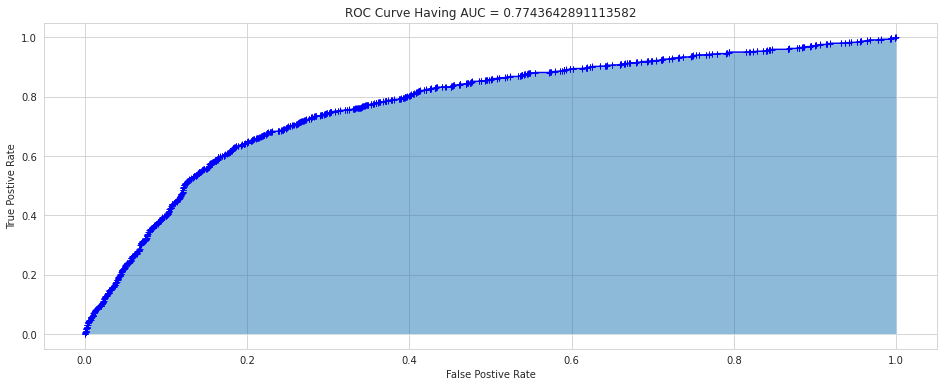

In [ ]:
plot_auc_curve(fpr, tpr, auc_test)

# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_smote, Y_smote, test_size = 0.2 ,random_state = 42)

clf = RandomForestClassifier()

clf.fit(X_train, y_train)

y_train_pred = clf.predict_proba(X_train)
y_train_pred_pos = y_train_pred[:,1]

y_val_pred = clf.predict_proba(X_val)
y_val_pred_pos = y_val_pred[:,1]

auc_train = roc_auc_score(y_train, y_train_pred_pos)
auc_test = roc_auc_score(y_val, y_val_pred_pos)

print(f"Train AUC Score {auc_train}")
print(f"Test AUC Score {auc_test}")

Train AUC Score 0.9999926711431626
Test AUC Score 0.9203634358731159


## Hyper-parameter tuning

In [ ]:
def optimize(params, param_names, x, y):
   

    # convert params to dictionary
    params = dict(zip(param_names, params))

    # initialize model with current parameters
    clf = RandomForestClassifier(**params)
    
    # initialize stratified k fold
    kf = StratifiedKFold(n_splits = 5)
    
    i = 0
    
    # initialize auc scores list
    auc_scores = []
    
    #loop over all folds
    for index in kf.split(X = x, y = y):
        train_index, test_index = index[0], index[1]
        
        
        
        x_train = x.iloc[train_index,:]
        y_train = y[train_index]

        smote = SMOTE(random_state = 446)
        x_train, y_train = smote.fit_resample(x_train,y_train)
        
        x_test = x.iloc[test_index,:]
        y_test = y[test_index]
        
        #fit model
        clf.fit(x_train, y_train)
        
        y_pred = clf.predict_proba(x_test)
        y_pred_pos = y_pred[:,1]
        
        auc = roc_auc_score(y_test, y_pred_pos)
        print(f'Current parameters of fold number {i} -> {params}')
        print(f'AUC score of test {i} f {auc}')

        i = i+1
        auc_scores.append(auc)
        
    return -1 * np.mean(auc_scores)

In [ ]:
#define a parameter space

param_spaces = [space.Integer(10, 200, name = 'n_estimators')]

# make a list of param names this has to be same order as the search space inside the main function
param_names = ['n_estimators']

# by using functools partial, i am creating a new function which has same parameters as the optimize function except 
# for the fact that only one param, i.e. the "params" parameter is required. 
# This is how gp_minimize expects the optimization function to be. 
# You can get rid of this by reading data inside the optimize function or by defining the optimize function here.

optimize_function = partial(optimize, param_names = param_names, x = X, y = Y)

In [ ]:
# output of this cell is very large that's why it is hidden

result = gp_minimize(optimize_function, dimensions = param_spaces, n_calls = 5, n_random_starts = 3, verbose = 10)

Iteration No: 1 started. Evaluating function at random point.
Current parameters of fold number 0 -> {'n_estimators': 86}
AUC score of test 0 f 0.7370488925809323
Current parameters of fold number 1 -> {'n_estimators': 86}
AUC score of test 1 f 0.7529458554710459
Current parameters of fold number 2 -> {'n_estimators': 86}
AUC score of test 2 f 0.7333200486981968
Current parameters of fold number 3 -> {'n_estimators': 86}
AUC score of test 3 f 0.7434412979050311
Current parameters of fold number 4 -> {'n_estimators': 86}
AUC score of test 4 f 0.7434935446992259
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 11.1658
Function value obtained: -0.7420
Current minimum: -0.7420
Iteration No: 2 started. Evaluating function at random point.
Current parameters of fold number 0 -> {'n_estimators': 183}
AUC score of test 0 f 0.7410047660337172
Current parameters of fold number 1 -> {'n_estimators': 183}
AUC score of test 1 f 0.7523668318387348
Current parameters of fold number

In [ ]:
best_params = dict(zip(param_names, result.x))
print(f'Best Parameters : {best_params}')
print(f'Best AUC score : {result.fun}')

Best Parameters : {'n_estimators': 174}
Best AUC score : -0.7443212508743204


let's again plot learning cuve with hyperparameters this time

In [ ]:
# splitting train and validation data

X_train, X_val, y_train, y_val = train_test_split(X,Y, test_size = 0.2, random_state = 24)

smote = SMOTE(random_state = 446)
X_train, y_train = smote.fit_resample(X_train,y_train)

In [ ]:
# initialize model with best parameters
clf = RandomForestClassifier(**best_params)

# fit model
clf.fit(X_train, y_train)

# predicting probabilities of training data
y_train_pred = clf.predict_proba(X_train)


y_train_pred_pos = y_train_pred[:,1]

y_val_pred = clf.predict_proba(X_val)
y_val_pred_pos = y_val_pred[:,1]

auc_train = roc_auc_score(y_train, y_train_pred_pos)
auc_test = roc_auc_score(y_val, y_val_pred_pos)

print(f"Train AUC Score {auc_train}")
print(f"Test AUC Score {auc_test}")

fpr, tpr, _ = roc_curve(y_val, y_val_pred_pos)

Train AUC Score 0.9999960114942483
Test AUC Score 0.7568803299438099


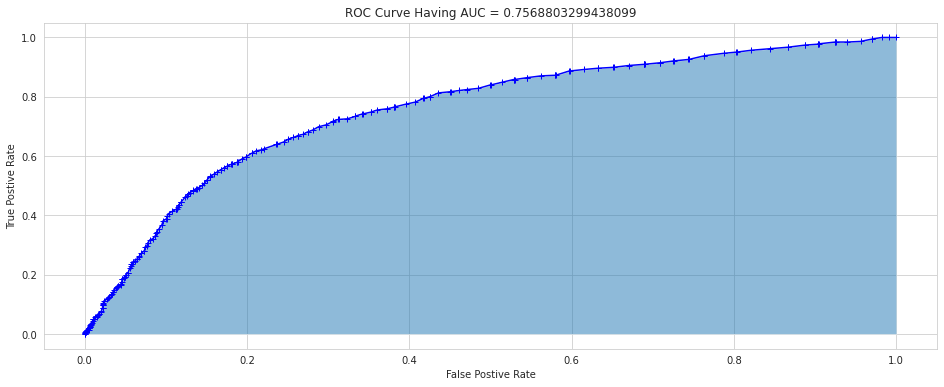

In [ ]:
plot_auc_curve(fpr, tpr, auc_test)

# Summary

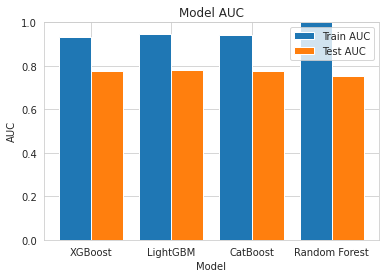

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt 

X_models = ['XGBoost','LightGBM','CatBoost','Random Forest']
Ytrain = [0.932,0.948,0.940,1.0]
Ztest = [0.777,0.781,0.776,0.754]
  
X_axis = np.arange(len(X_models))
  
plt.bar(X_axis - 0.2, Ytrain, 0.4, label = 'Train AUC')
plt.bar(X_axis + 0.2, Ztest, 0.4, label = 'Test AUC')

plt.ylim([0,1])
# plt.xlim([-0.5,3])
plt.xticks(X_axis, X_models)
plt.xlabel("Model")
plt.ylabel("AUC")
plt.title("Model AUC")
plt.legend()
plt.show()

# Reference <a id = "9" ></a>

1. [Plots for missing values](https://towardsdatascience.com/working-with-missing-data-in-machine-learning-9c0a430df4ce)
2. [To plot dendrogram](https://coderzcolumn.com/tutorials/data-science/missingno-visualize-missing-data-in-python)
3. [Statistical Imputation for Missing Values in Machine Learning](https://machinelearningmastery.com/statistical-imputation-for-missing-values-in-machine-learning/)
4. [K-Nearest Neighbor(KNN) Algorithm for Machine Learning](https://www.javatpoint.com/k-nearest-neighbor-algorithm-for-machine-learning)
5. [Machine Learning Git repo](https://github.com/rachittoshniwal/machineLearning)
6. [Joins in Pandas](https://www.analyticsvidhya.com/blog/2020/02/joins-in-pandas-master-the-different-types-of-joins-in-python/)
7. [Handling Imbalanced Data with SMOTE](https://www.geeksforgeeks.org/ml-handling-imbalanced-data-with-smote-and-near-miss-algorithm-in-python)
8. [Encoding Methodologies](https://www.datacamp.com/community/tutorials/encoding-methodologies)
9. [Why Normalization is not required for tree based models](https://www.kaggle.com/c/m5-forecasting-accuracy/discussion/160613)
10. [SMOTE](https://imbalanced-learn.org/stable/generated/imblearn.over_sampling.SMOTE.html)
11. [Kaggle notebook for Categorical Encoding Methods](https://www.kaggle.com/arashnic/an-overview-of-categorical-encoding-methods)
12. [Interpretation of Performance Measures](https://blog.exsilio.com/all/accuracy-precision-recall-f1-score-interpretation-of-performance-measures/)
13. [How to Implement Bayesian Optimization from Scratch in Python](https://machinelearningmastery.com/what-is-bayesian-optimization/)

## Books

1. [Hands–On Machine Learning with Scikit–Learn and TensorFlow 2](https://www.amazon.in/Hands-Machine-Learning-Scikit-Learn-TensorFlow-dp-1492032646/dp/1492032646/ref=dp_ob_title_bk)
2. [Approaching (Almost) Any Machine Learning Problem](https://github.com/abhishekkrthakur/approachingalmost)
